In [1]:
try:
    import matplotlib
except ImportError as e:
    !pip install matplotlib

try:
    import torch
except ImportError as e:
    !pip intalll torch
    
try:
    import torchvision
except ImportError as e:
    !pip intalll torctorchvisionh

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms
from torch.utils.data import dataset
from  matplotlib import pyplot as plt
import os

print('This is an implemention about Gnerative Adversarial Networks based on Pytorch. ')
print('The network induces an additional attention module to improve the performance')
print('the dataset used is cifar10')

This is an implemention about Gnerative Adversarial Networks based on Pytorch. 
The network induces an additional attention module to improve the performance
the dataset used is cifar10


In [3]:
batch_size = 32
latent_size = 100
epoch_num = 20

In [4]:
# Load Data Cifar10 32x32
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10('./CIFARdata', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

dataset_size = len(trainloader)
print("cifar10 contains %d images"% (len(trainset)))

Files already downloaded and verified
cifar10 contains 50000 images


In [5]:
class Attention(nn.Module):
    def __init__(self, in_channel):
        super(Attention,self).__init__()
        self.in_channel = in_channel
        out_channel = [in_channel//4, in_channel]
        
        self.query = nn.Conv2d(in_channel, out_channel[0], kernel_size=1)
        self.key = nn.Conv2d(in_channel, out_channel[0], kernel_size=1)
        self.value = nn.Conv2d(in_channel, out_channel[1], kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1)
        
    def forward(self,inputs):
        B, C, W ,H = inputs.shape
        
        query = self.query(inputs).view(B, -1, W*H).permute(0,2,1) # B, W*H, C
        key = self.key(inputs).view(B, -1, W*H) # B, C, W*H
        energy = torch.bmm(query, key) # B, W*H, W*H
        attention = self.softmax(energy) # B, W*H, W*H

        value = self.value(inputs).view(B, -1, W*H) # B, C, W*H

        out = torch.bmm(value,attention.permute(0,2,1)) # B, C, W*H
        out = out.view(B, C, W, H) # B, C, W, H
        
        out = self.gamma*out + inputs
        return out
    


In [6]:
class Discriminator(torch.nn.Module):
    def __init__(self, img_channel=3, c=64):
        super(Discriminator, self).__init__()

        def down_sampling(in_channel, out_channel, kernel_size):
            return nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=2, padding=(kernel_size - 1) // 2),
                nn.BatchNorm2d(out_channel),
                nn.LeakyReLU(0.2, inplace=True),
            )

        self.layer1 = down_sampling(img_channel, c, 4)  # B, 64, 16, 16
        self.layer2 = down_sampling(c, c * 2, 4)  # B, 128, 8, 8
        self.layer3 = down_sampling(c * 2, c * 4, 4)  # B, 256, 4, 4

        self.predict = nn.Sequential(
            nn.Linear(c * 4 * 4 * 4, 1),
            nn.Sigmoid())  # # B, 1, 1, 1
        
        self.attention1 = Attention(128)
        self.attention2 = Attention(256)

    def forward(self, inputs):
        layer1 = self.layer1(inputs)
        
        layer2 = self.layer2(layer1)
        layer2 = self.attention1(layer2)
        
        layer3 = self.layer3(layer2)
        layer3 = self.attention2(layer3)
        
        #layer4 = self.layer4(layer3)
        output = self.predict(layer3.view(layer3.size(0), -1))
        return output


D_net = Discriminator().cuda()
print(D_net)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (predict): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (attention1): Attention(
    (query): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (key): Conv2d(128, 32, kernel_size=(1, 1),

In [7]:
class Generator(torch.nn.Module):
    def __init__(self, latent_size=latent_size, c=64, img_channel=3):
        super(Generator, self).__init__()

        def up_sampling(in_channel, out_channel, kernel_size):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=2,
                                   padding=1),
                nn.BatchNorm2d(out_channel),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.layer1 = nn.Sequential(nn.Linear(latent_size, c * 8 * 4 * 4))  # B, 512*4*4
        self.layer2 = up_sampling(c * 8, c * 4, 4)  # B, 256, 8, 8
        self.layer3 = up_sampling(c * 4, c * 2, 4)  # B, 128, 16, 16
        self.layer4 = up_sampling(c * 2, c, 4)  # B, 64, 32, 32

        self.output = nn.Sequential(
            nn.Conv2d(c, img_channel, kernel_size=1),
            nn.Tanh())  # B, 3, 32, 32

        self.attention1 = Attention(256)
        self.attention2 = Attention(128)

    def forward(self, inputs):
        layer1 = self.layer1(inputs).view(inputs.size(0), 512, 4, 4)
        layer2 = self.layer2(layer1)
        layer2 = self.attention1(layer2)
        layer3 = self.layer3(layer2)
        layer3 = self.attention2(layer3)
        layer4 = self.layer4(layer3)
        output = self.output(layer4)
        return output
        
G_net = Generator().cuda()
print(G_net)

Generator(
  (layer1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (output): Sequential(
    (0): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): Tanh()
  )
  (attention1): Attention(


In [8]:
D_optimizer = torch.optim.Adam(D_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(G_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
crit_loss = nn.BCELoss()

In [9]:
def convert_show_image(tensor, row_num=4, colomn_num=4):
    for r in range(row_num):
        for c in range(colomn_num):
            img_show_row = tensor[r * colomn_num + c] if c ==0 else torch.cat((img_show_row, tensor[r * colomn_num + c]), 2)
        img_show = img_show_row if r ==0 else torch.cat((img_show, img_show_row), 1)
    return img_show

epoch 1, step 1: d_loss 0.701528, g_loss 1.290094


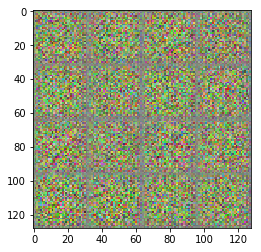

epoch 1, step 301: d_loss 0.509075, g_loss 1.570036


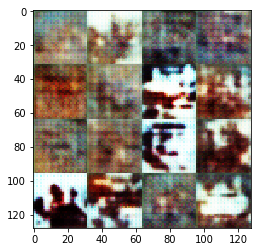

epoch 1, step 601: d_loss 0.433341, g_loss 1.714111


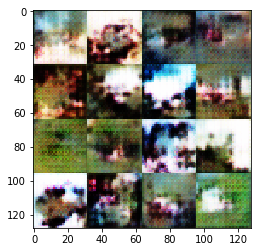

epoch 1, step 901: d_loss 0.229405, g_loss 2.032143


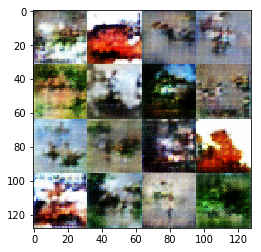

epoch 1, step 1201: d_loss 0.591123, g_loss 1.480208


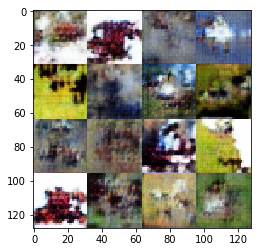

epoch 1, step 1501: d_loss 0.235069, g_loss 2.420503


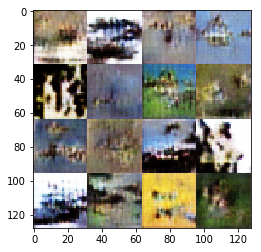

epoch 2, step 1: d_loss 0.359335, g_loss 1.746764


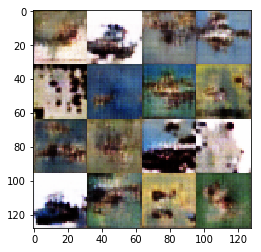

epoch 2, step 301: d_loss 0.139840, g_loss 2.890304


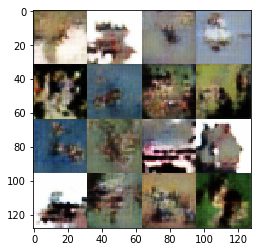

epoch 2, step 601: d_loss 0.076874, g_loss 3.902581


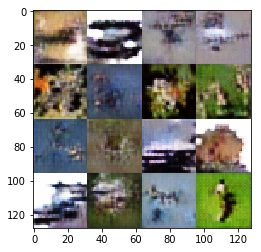

epoch 2, step 901: d_loss 0.315352, g_loss 2.012115


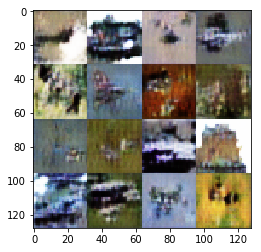

epoch 2, step 1201: d_loss 0.572266, g_loss 2.074109


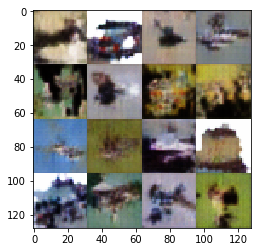

epoch 2, step 1501: d_loss 0.280682, g_loss 2.152489


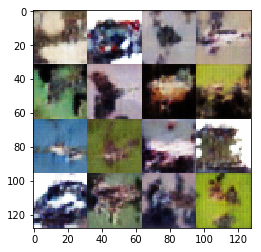

epoch 3, step 1: d_loss 0.206608, g_loss 2.263320


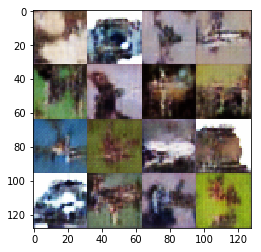

epoch 3, step 301: d_loss 0.032087, g_loss 3.870973


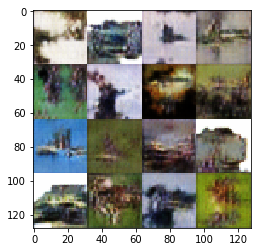

epoch 3, step 601: d_loss 0.020175, g_loss 4.344622


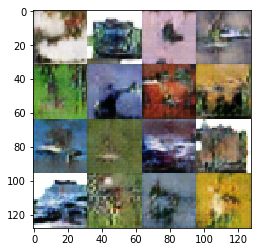

epoch 3, step 901: d_loss 0.358394, g_loss 2.432666


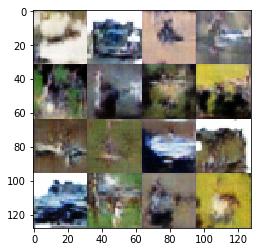

epoch 3, step 1201: d_loss 0.147901, g_loss 4.123964


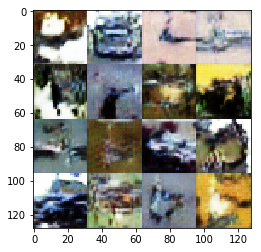

epoch 3, step 1501: d_loss 0.208641, g_loss 2.773550


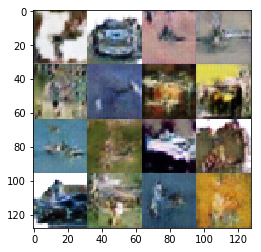

epoch 4, step 1: d_loss 0.314446, g_loss 2.132138


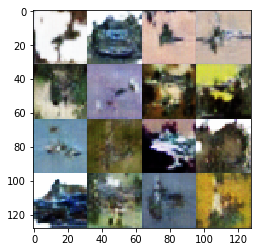

epoch 4, step 301: d_loss 0.026873, g_loss 4.599115


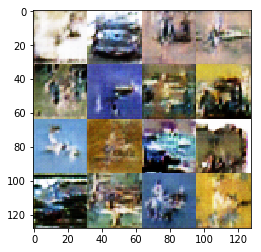

epoch 4, step 601: d_loss 0.214493, g_loss 2.918648


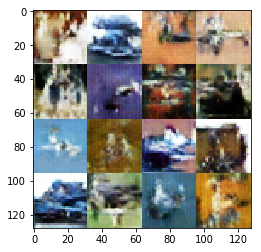

epoch 4, step 901: d_loss 0.094325, g_loss 4.516457


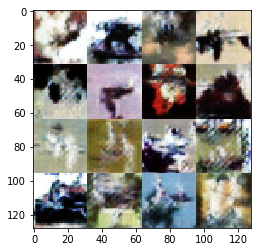

epoch 4, step 1201: d_loss 0.255856, g_loss 2.520609


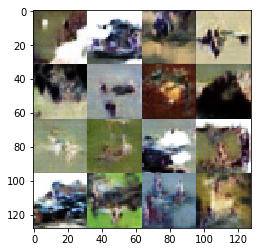

epoch 4, step 1501: d_loss 0.062939, g_loss 3.848492


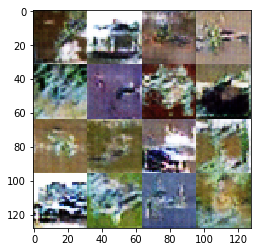

epoch 5, step 1: d_loss 0.022830, g_loss 4.554811


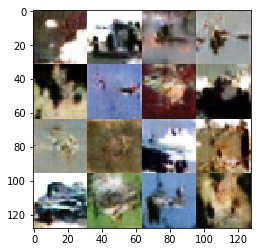

epoch 5, step 301: d_loss 0.188993, g_loss 2.837637


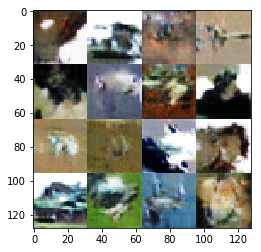

epoch 5, step 601: d_loss 0.281200, g_loss 3.055863


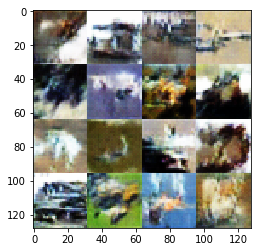

epoch 5, step 901: d_loss 0.139058, g_loss 5.188798


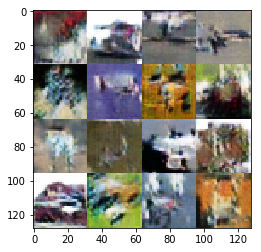

epoch 5, step 1201: d_loss 0.030873, g_loss 4.522162


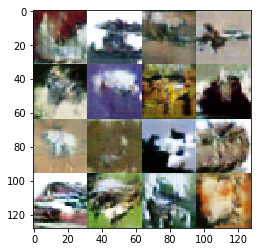

epoch 5, step 1501: d_loss 0.146726, g_loss 3.044872


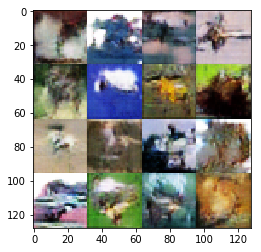

epoch 6, step 1: d_loss 0.856455, g_loss 2.203248


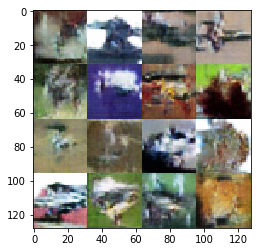

epoch 6, step 301: d_loss 0.002966, g_loss 5.981973


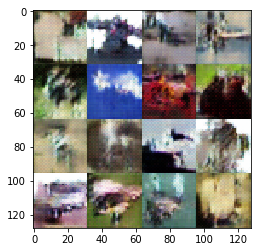

epoch 6, step 601: d_loss 0.002348, g_loss 6.551326


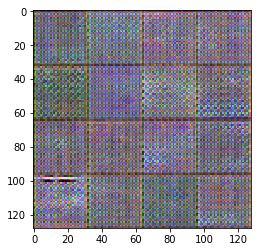

epoch 6, step 901: d_loss 0.030293, g_loss 7.108771


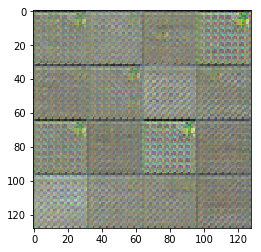

epoch 6, step 1201: d_loss 0.019689, g_loss 6.978470


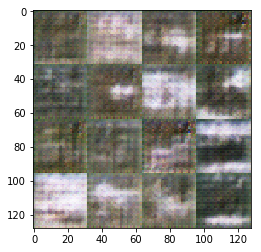

epoch 6, step 1501: d_loss 0.036688, g_loss 5.613214


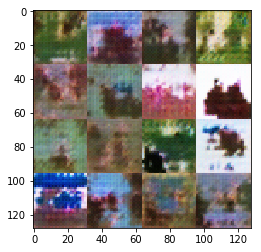

epoch 7, step 1: d_loss 0.035049, g_loss 4.208534


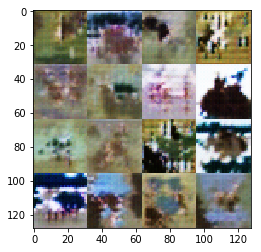

epoch 7, step 301: d_loss 0.039192, g_loss 4.738296


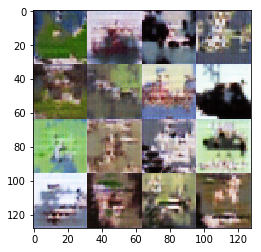

epoch 7, step 601: d_loss 0.035355, g_loss 5.744357


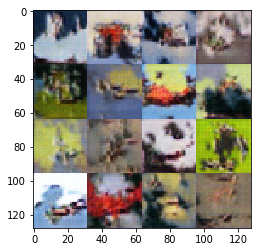

epoch 7, step 901: d_loss 0.071731, g_loss 5.877441


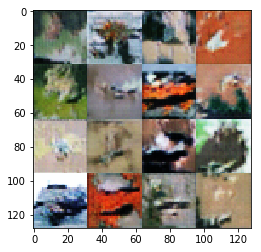

epoch 7, step 1201: d_loss 0.017166, g_loss 3.855386


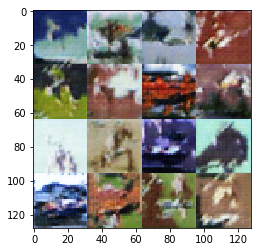

epoch 7, step 1501: d_loss 0.070972, g_loss 9.782440


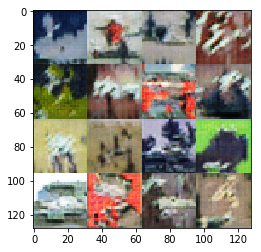

epoch 8, step 1: d_loss 0.335266, g_loss 9.211020


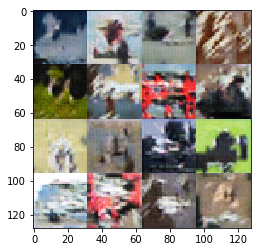

epoch 8, step 301: d_loss 0.019036, g_loss 6.681034


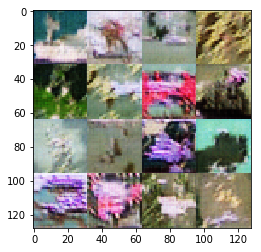

epoch 8, step 601: d_loss 0.029929, g_loss 7.438928


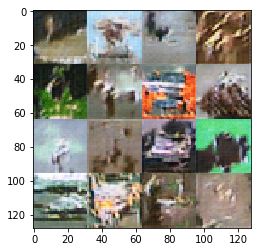

epoch 8, step 901: d_loss 0.308502, g_loss 8.526863


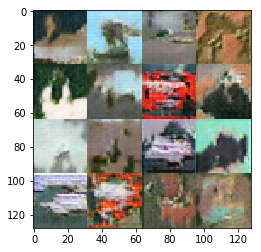

epoch 8, step 1201: d_loss 0.044562, g_loss 4.350642


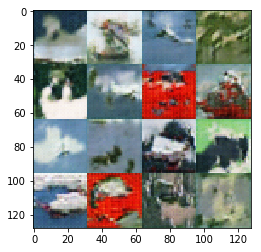

epoch 8, step 1501: d_loss 0.252769, g_loss 10.001354


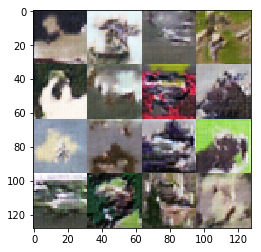

epoch 9, step 1: d_loss 0.713213, g_loss 4.239438


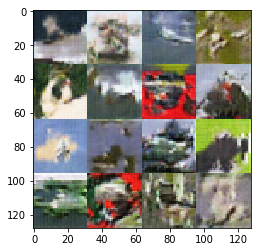

epoch 9, step 301: d_loss 0.011417, g_loss 5.960734


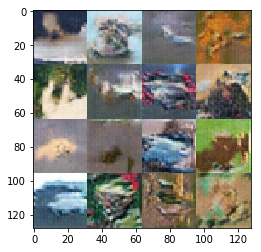

epoch 9, step 601: d_loss 0.006548, g_loss 6.547564


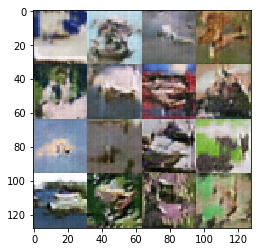

epoch 9, step 901: d_loss 0.123431, g_loss 5.703357


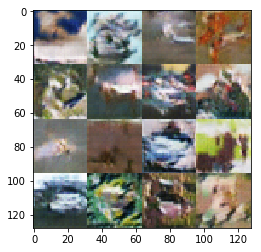

epoch 9, step 1201: d_loss 0.229814, g_loss 4.767475


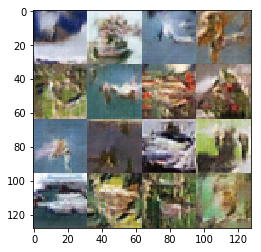

epoch 9, step 1501: d_loss 0.069945, g_loss 4.528336


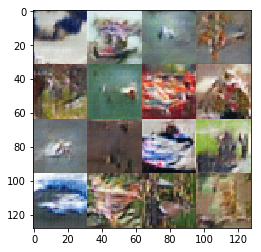

epoch 10, step 1: d_loss 0.118177, g_loss 5.757436


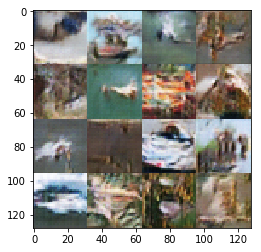

epoch 10, step 301: d_loss 0.087942, g_loss 6.328582


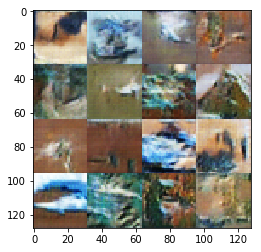

epoch 10, step 601: d_loss 0.018204, g_loss 4.599312


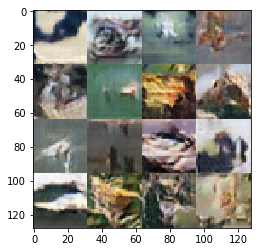

epoch 10, step 901: d_loss 0.042367, g_loss 6.951104


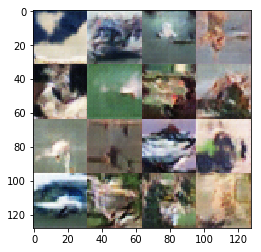

epoch 10, step 1201: d_loss 0.699727, g_loss 8.821436


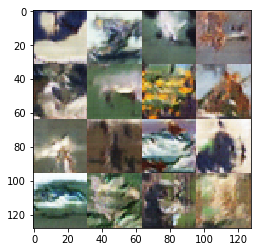

epoch 10, step 1501: d_loss 0.199761, g_loss 6.431794


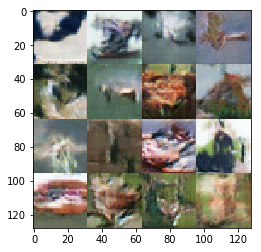

epoch 11, step 1: d_loss 0.226374, g_loss 6.063583


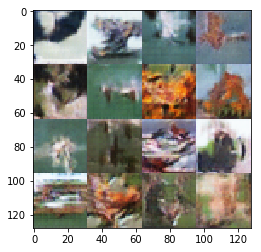

epoch 11, step 301: d_loss 0.105374, g_loss 6.587929


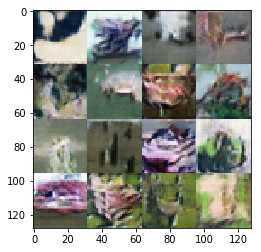

epoch 11, step 601: d_loss 0.179305, g_loss 4.286911


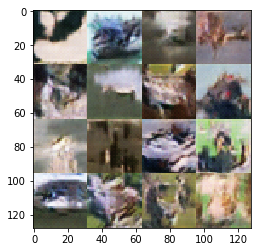

epoch 11, step 901: d_loss 0.174155, g_loss 3.466220


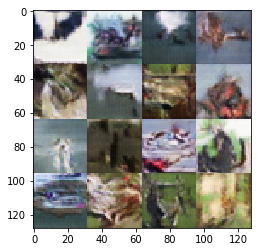

epoch 11, step 1201: d_loss 0.013594, g_loss 5.417647


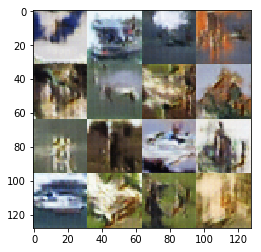

epoch 11, step 1501: d_loss 0.561369, g_loss 5.699273


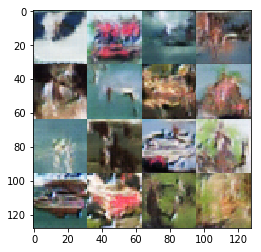

epoch 12, step 1: d_loss 0.097618, g_loss 4.600621


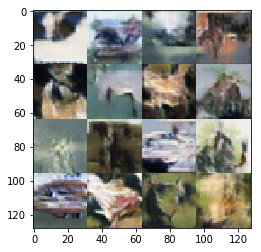

epoch 12, step 301: d_loss 0.069261, g_loss 4.665462


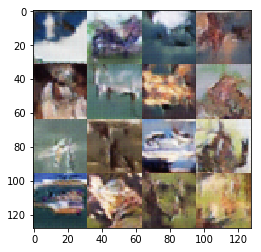

epoch 12, step 601: d_loss 0.039791, g_loss 4.280989


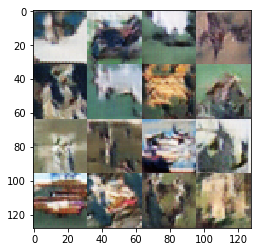

epoch 12, step 901: d_loss 0.031304, g_loss 4.806585


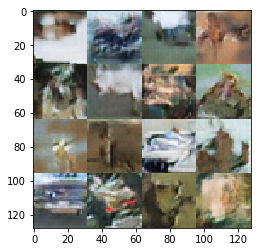

epoch 12, step 1201: d_loss 0.070811, g_loss 2.995221


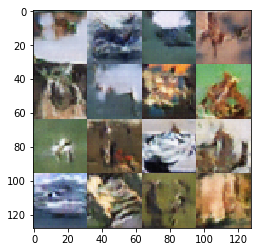

epoch 12, step 1501: d_loss 0.226373, g_loss 3.937043


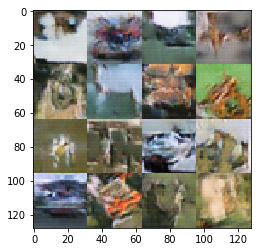

epoch 13, step 1: d_loss 0.112645, g_loss 3.881017


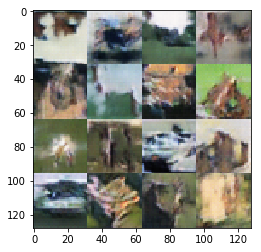

epoch 13, step 301: d_loss 0.022468, g_loss 6.126437


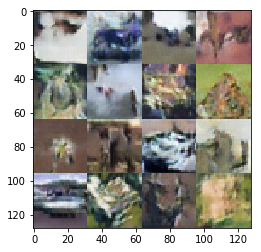

epoch 13, step 601: d_loss 0.068742, g_loss 5.004938


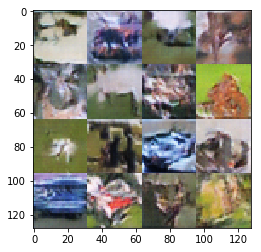

epoch 13, step 901: d_loss 0.023696, g_loss 5.283183


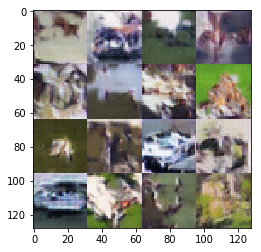

epoch 13, step 1201: d_loss 0.092532, g_loss 3.637419


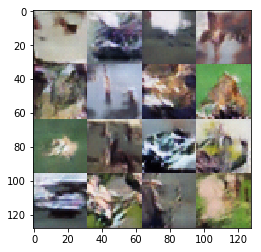

epoch 13, step 1501: d_loss 0.067021, g_loss 4.807445


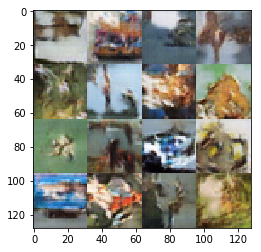

epoch 14, step 1: d_loss 0.265270, g_loss 4.402894


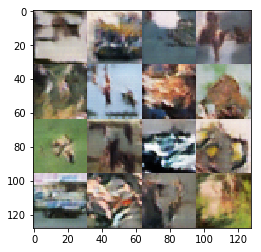

epoch 14, step 301: d_loss 0.023617, g_loss 2.218796


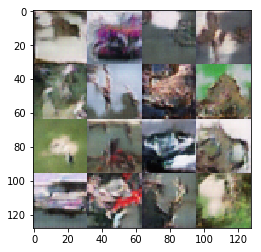

epoch 14, step 601: d_loss 0.186218, g_loss 4.590537


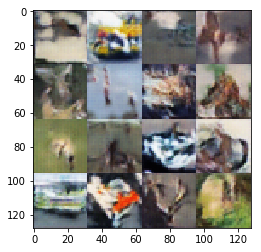

epoch 14, step 901: d_loss 0.123075, g_loss 3.460278


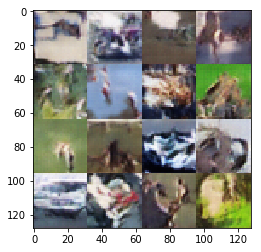

epoch 14, step 1201: d_loss 0.026345, g_loss 6.365366


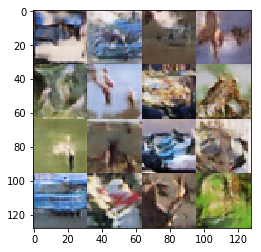

epoch 14, step 1501: d_loss 0.120967, g_loss 3.972701


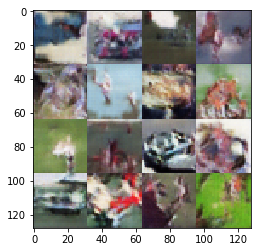

epoch 15, step 1: d_loss 0.120308, g_loss 5.112395


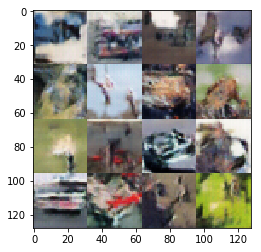

epoch 15, step 301: d_loss 0.490021, g_loss 1.492314


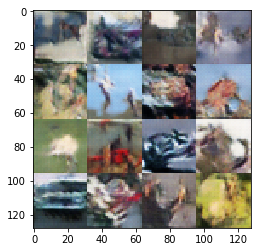

epoch 15, step 601: d_loss 0.035915, g_loss 6.895335


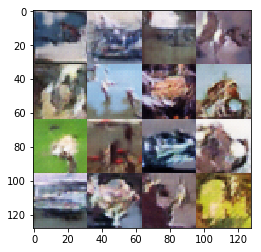

epoch 15, step 901: d_loss 0.129349, g_loss 5.146078


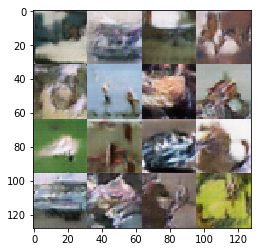

epoch 15, step 1201: d_loss 0.155974, g_loss 7.702597


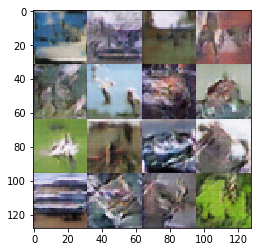

epoch 15, step 1501: d_loss 0.143094, g_loss 3.858202


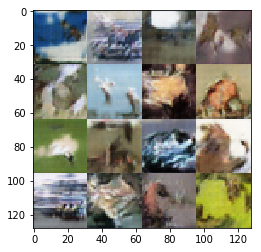

epoch 16, step 1: d_loss 0.776013, g_loss 6.071077


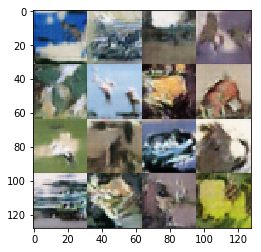

epoch 16, step 301: d_loss 0.032569, g_loss 4.428617


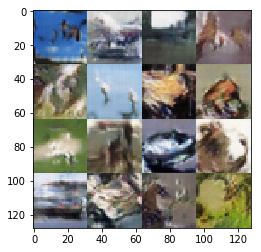

epoch 16, step 601: d_loss 0.386620, g_loss 5.393164


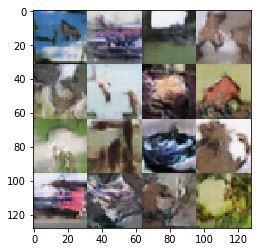

epoch 16, step 901: d_loss 0.149176, g_loss 4.164927


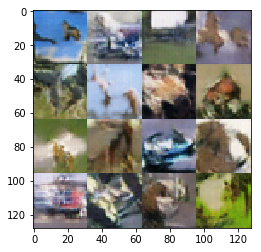

epoch 16, step 1201: d_loss 0.099003, g_loss 3.941745


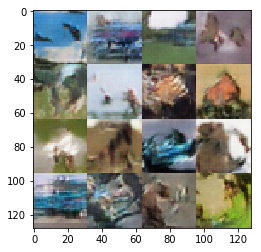

epoch 16, step 1501: d_loss 0.233726, g_loss 2.661189


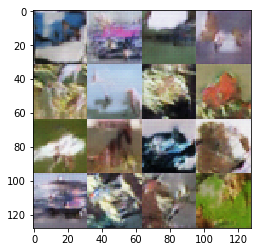

epoch 17, step 1: d_loss 1.742459, g_loss 6.610625


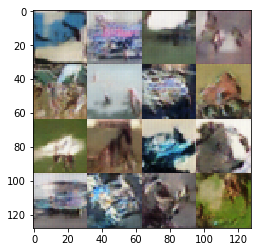

epoch 17, step 301: d_loss 0.036252, g_loss 4.812284


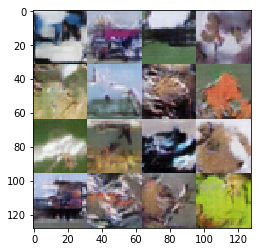

epoch 17, step 601: d_loss 0.084170, g_loss 5.360765


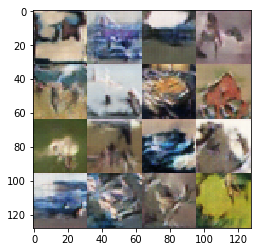

epoch 17, step 901: d_loss 0.066201, g_loss 4.146881


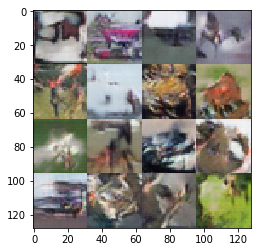

epoch 17, step 1201: d_loss 0.157767, g_loss 2.832746


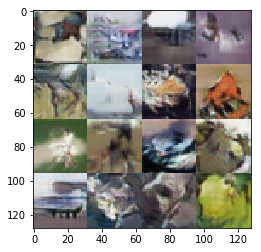

epoch 17, step 1501: d_loss 0.090355, g_loss 3.884640


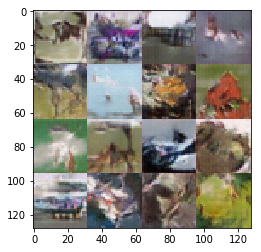

epoch 18, step 1: d_loss 0.028322, g_loss 4.276383


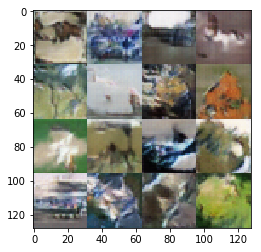

epoch 18, step 301: d_loss 0.446441, g_loss 10.857142


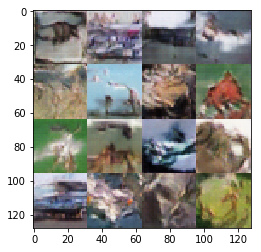

epoch 18, step 601: d_loss 0.973766, g_loss 10.581978


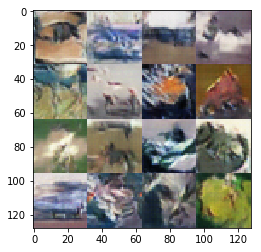

epoch 18, step 901: d_loss 0.344519, g_loss 3.922709


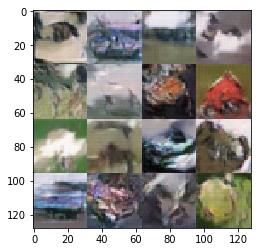

epoch 18, step 1201: d_loss 0.022232, g_loss 7.132719


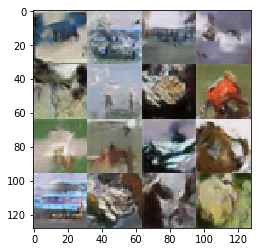

epoch 18, step 1501: d_loss 0.555870, g_loss 4.139107


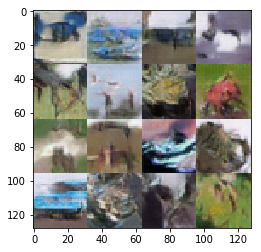

epoch 19, step 1: d_loss 0.220312, g_loss 3.384794


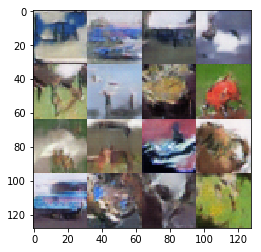

epoch 19, step 301: d_loss 0.009573, g_loss 8.816019


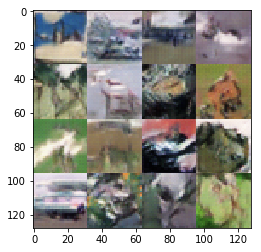

epoch 19, step 601: d_loss 0.021152, g_loss 5.846726


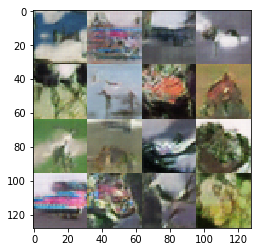

epoch 19, step 901: d_loss 0.221038, g_loss 5.319298


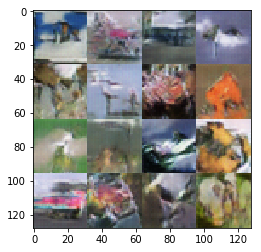

epoch 19, step 1201: d_loss 0.088952, g_loss 3.862223


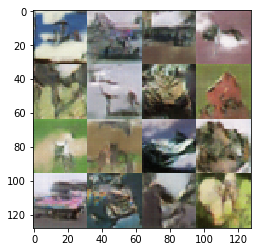

epoch 19, step 1501: d_loss 0.539142, g_loss 4.532101


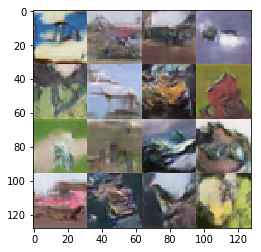

epoch 20, step 1: d_loss 0.547660, g_loss 5.633445


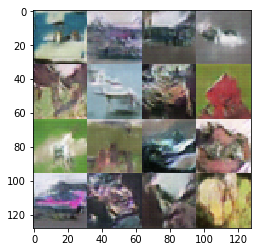

epoch 20, step 301: d_loss 0.032628, g_loss 7.315693


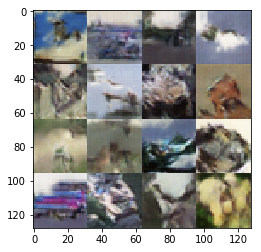

epoch 20, step 601: d_loss 0.200492, g_loss 5.249944


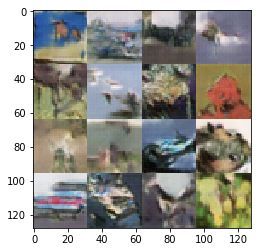

epoch 20, step 901: d_loss 0.151891, g_loss 5.427637


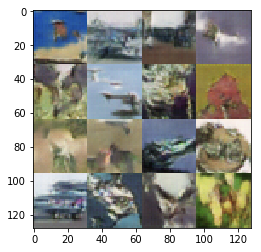

epoch 20, step 1201: d_loss 0.013817, g_loss 5.233306


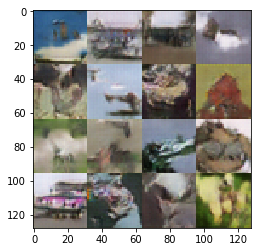

epoch 20, step 1501: d_loss 0.068563, g_loss 4.840856


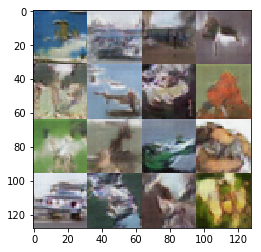

Done!


In [10]:
fixed_latent = torch.randn(16, latent_size).cuda()

    
G_net.train()
D_net.train()

for epoch in range(epoch_num):
    
    for step, data in enumerate(trainloader):
        real_images, _ = data
        real_images = real_images.cuda()
        
        B = real_images.size(0)
        
        latent = torch.randn(B, latent_size).cuda()
        fake_images = G_net(latent)
        
        one_labels = torch.ones(B, 1).cuda()
        zero_labels = torch.zeros(B, 1).cuda()
        
        D_optimizer.zero_grad()
        d_loss_real = crit_loss(D_net(real_images), one_labels)
        d_loss_fake = crit_loss(D_net(fake_images.detach()), zero_labels)
        D_loss = (d_loss_real + d_loss_fake) / 2
        D_loss.backward()
        D_optimizer.step()
        
        G_optimizer.zero_grad()
        G_loss = crit_loss(D_net(fake_images), one_labels)
        G_loss.backward()
        G_optimizer.step()
        
        
        if step % 300 == 0:
            fake_images = G_net(fixed_latent)
            show_image = convert_show_image(fake_images)
            show_image = ((0.5 * (show_image.detach().cpu().numpy()) + 0.5) * 255).transpose(1,2,0).astype(np.uint8)
            
            print("epoch %d, step %d: d_loss %f, g_loss %f"%((epoch + 1), (step + 1), D_loss, G_loss))
            
            plt.imshow(show_image)
            plt.show()
            
    torch.save(G_net.state_dict(), 'D_net_best.pth')
    torch.save(D_net.state_dict(), 'G_net_best.pth')
    
print('Done!')


